In [1]:
import io

import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm
import numpy as np
import netCDF4
import cmocean
import colorcet
import scipy.interpolate


import coastviewer.extra_cm
%matplotlib inline

In [2]:
DATASETS = {
    'transect': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/jarkus/profiles/transect.nc',  # nopep8
    'BKL_TKL_TND': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/BKL_TKL_MKL/BKL_TKL_TND.nc',  # nopep8
    'DF': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/DuneFoot/DF.nc',  # nopep8
    'mkl': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/BKL_TKL_MKL/MKL.nc',  # nopep8
    'strandbreedte': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/strandbreedte/strandbreedte.nc',  # nopep8
    'mhw_mlw': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/MHW_MLW/MHW_MLW.nc',  # nopep8
    'nourishments': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/suppleties/nourishments.nc',  # nopep8
    'faalkans': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/faalkans_PC-Ring/faalkans.nc'  # nopep8
}
local = True
if local:
    DATASETS['transect'] = str(pathlib.Path('../data/transect.nc'))


In [3]:
# global variables
with netCDF4.Dataset(DATASETS['transect']) as ds:
    # keep these global, for faster indexing
    ids = ds.variables['id'][:]
    print(ds.variables['mean_high_water'])

<class 'netCDF4._netCDF4.Variable'>
float64 mean_high_water(alongshore)
    long_name: mean high water level
    units: m
    comment: mean high water level relative to nap
unlimited dimensions: 
current shape = (2268,)
filling off



In [4]:
def fill(z):
    """fill z by space and then time"""
    def fill_space(z):
        """fill space"""
        x = np.arange(z.shape[0])
        F = scipy.interpolate.interp1d(x[~z.mask], z[~z.mask], bounds_error=False)
        z_interp = F(x)
        z_filled = np.ma.masked_invalid(z_interp)
        return z_filled
    def fill_time(z):
        """fill time"""
        z_filled = np.ma.masked_all_like(z)
        for i in range(z.shape[1]):
            arr = z[:, i]
            # if there's no data, continue
            if arr.mask.all():
                continue
            # interpolate in time
            xp = np.arange(len(arr))
            z_filled[:, i] = scipy.interp(xp, xp[~arr.mask], arr[~arr.mask])
        return z_filled

    filled_z = np.ma.apply_along_axis(fill_space, 1, z)
    filled_z = fill_time(filled_z)
    return filled_z

    

In [5]:
def get_transect_data(id_=7003900):
    transect_idx = np.searchsorted(ids, id_)
    variables = {
        'lat': {"var": 'lat', "slice": np.s_[transect_idx, :]},
        'lon': {"var": 'lon', "slice": np.s_[transect_idx, :]},
        'z': {"var": 'altitude', "slice": np.s_[:, transect_idx, :]},
        "t": {"var": 'time', "slice": np.s_[:]},
        "cross_shore": {"var": "cross_shore", "slice": np.s_[:]},
        'mean_high_water': {"var": 'mean_high_water', "slice": np.s_[transect_idx]},
        'mean_low_water': {"var": 'mean_low_water', "slice": np.s_[transect_idx]},


    }
    data = {}
    with netCDF4.Dataset(DATASETS['transect']) as ds:
        for var, props in variables.items():
            data[var] = ds.variables[props['var']][props['slice']]
        time_units = ds.variables['time'].units
    data['time'] = netCDF4.num2date(data['t'], time_units)
    data['filled_z'] = fill(data['z'])
    data['time_num'] = matplotlib.dates.date2num(data['time'])
    return data


In [6]:
def time_map(data):
    fig, ax = plt.subplots(figsize=(13, 8))
    pc = ax.pcolorfast(data['cross_shore'], data['time_num'], data['filled_z'], vmin=-20, vmax=20, cmap=coastviewer.extra_cm.GMT_drywet_r)
    cont = ax.contour(
        data['cross_shore'], 
        data['time_num'], 
        data['z'],
        levels=[data['mean_low_water'], data['mean_high_water'], 3],
        cmap='PuBu'
    )
    # legend
    cb = plt.colorbar(pc, ax=ax)

    # labels
    cb.set_label('Height to NAP [m]')
    ax.set_xlabel('Cross shore distance [m]')
    ax.set_ylabel('Measurement time [y]')

    # date format
    date_locator = matplotlib.dates.AutoDateLocator()
    date_formatter = matplotlib.dates.AutoDateFormatter(date_locator)
    ax.yaxis.set_major_formatter(date_formatter)
    
    # cleanup a bit
    ax.set_xlim(data['cross_shore'].min(), data['cross_shore'].max())
    fig.tight_layout()
    return fig, ax

In [7]:

def eeg(data):
    t = data['time_num']
    x = data['cross_shore']
    # and data
    z = data['z']
    nrows, nsamples = z.shape

    # create a line for each timeseries
    segs = []
    ticklocs = []
    for i, row in enumerate(z):
        # add a line, scale it by the y axis each plot has a range of the elevation divided by 7.5 (~2 years up and down)
        pts = np.c_[
            x[~z[i, :].mask],
            z[i, ~z[i,:].mask].filled()*365.0/7.5
        ]

        segs.append(pts)

        ticklocs.append(t[i]) # use date for yloc
    # create an offset for each line
    offsets = np.zeros((nrows, 2), dtype=float)
    offsets[:, 1] = ticklocs
    # create the lines
    lines = matplotlib.collections.LineCollection(segs, offsets=offsets)
    # create a new figure
    fig, ax = plt.subplots(figsize=(13, 8))
    ax.add_collection(lines)
    # set the x axis
    ax.set_xlim(x.min(), x.max())
    # set the y axis (add a bit of room cause the wiggles go over a few years)
    # changed maximum correction days to 1000 from 730 (2 years), because
    # sometimes upper line was outside the y limits
    ax.set_ylim(t.min()-730, t.max()+1000)
    ax.set_xlabel('Cross shore distance [m]')
    ax.set_ylabel('Measurement time [y]')

    date_locator = matplotlib.dates.AutoDateLocator()
    date_formatter = matplotlib.dates.AutoDateFormatter(date_locator)
    ax.yaxis.set_major_formatter(date_formatter)
    return fig, ax

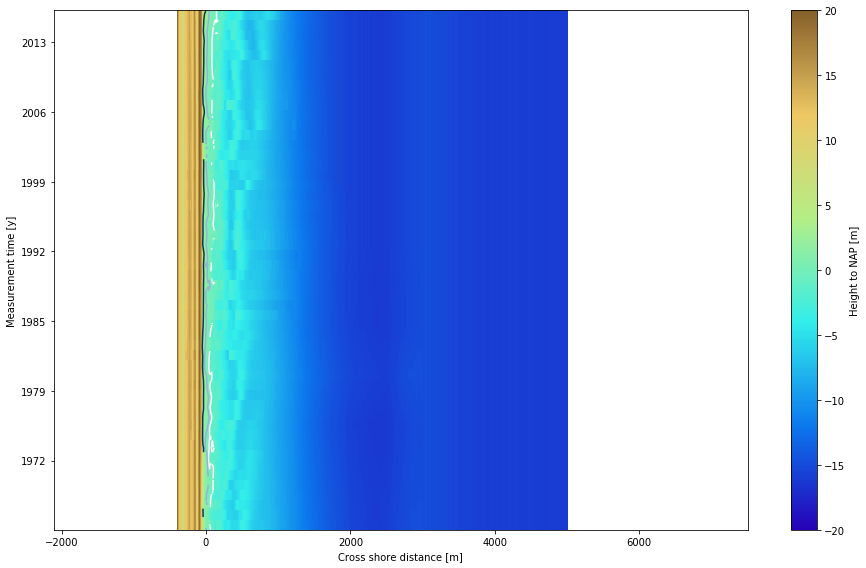

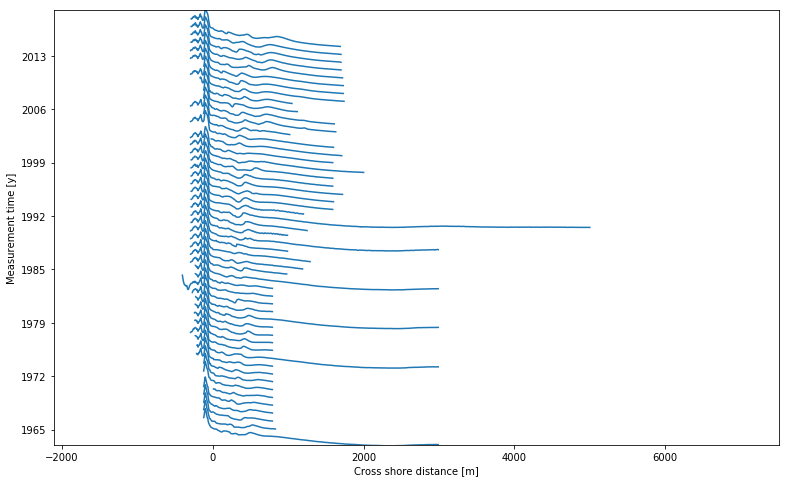

In [8]:
data = get_transect_data()
fig, ax = time_map(data)
fig, ax = eeg(data)



In [9]:
fig, ax

stream = io.BytesIO()
fig.savefig(stream)
stream.getvalue()[:10]

b'\x89PNG\r\n\x1a\n\x00\x00'

In [10]:
def get_mean_water_df(id=7003900):
    transect_idx = np.searchsorted(ids, id)

    variables = {
        'mean_high_water_cross': {"var": 'mean_high_water_cross', "slice": np.s_[:, transect_idx]},
        'mean_low_water_cross': {"var": 'mean_low_water_cross', "slice": np.s_[:, transect_idx]},
        "t": {"var": 'time', "slice": np.s_[:]}
    }
    data = {}
    with netCDF4.Dataset(DATASETS['mhw_mlw']) as ds:
        for var, props in variables.items():
            data[var] = ds.variables[props['var']][props['slice']]
        time_units = ds.variables['time'].units
    data['time'] = netCDF4.num2date(data['t'], time_units)

    shoreline_df = pd.DataFrame(data)
    return shoreline_df

In [11]:
def get_dune_foot_df(id=7003900):
    id=7003900
    transect_idx = np.searchsorted(ids, id)

    variables = {
        'dune_foot_upperMKL_cross': {"var": 'dune_foot_upperMKL_cross', "slice": np.s_[:, transect_idx]},
        'dune_foot_threeNAP_cross': {"var": 'dune_foot_threeNAP_cross', "slice": np.s_[:, transect_idx]},
        "t": {"var": 'time', "slice": np.s_[:]}
    }
    data = {}
    with netCDF4.Dataset(DATASETS['DF']) as ds:
        for var, props in variables.items():
            data[var] = ds.variables[props['var']][props['slice']]
        time_units = ds.variables['time'].units
    data['time'] = netCDF4.num2date(data['t'], time_units)

    shoreline_df = pd.DataFrame(data)
    return shoreline_df

In [56]:
"""Read the nourishments from the dataset (only store the variables that are a function of nourishment)"""
def get_nourishment_grid_df(id=7003900):
    transect_idx = np.searchsorted(ids, id)
    variables = {
        'type': {"var": 'type', "slice": np.s_[:]},
        "volume": {"var": "volume", "slice": np.s_[transect_idx,:,:]},
        "time_num_start": {"var": "time_start", "slice": np.s_[transect_idx,:,:]},
        "time_num_end": {"var": "time_end", "slice": np.s_[transect_idx,:,:]},
        "t": {"var": 'time', "slice": np.s_[:]}
    }

    data = {}
    with netCDF4.Dataset(DATASETS['nourishments']) as ds:
        for var, props in variables.items():
            data[var] = ds.variables[props['var']][props['slice']]
        time_units = ds.variables['time'].units
        time_start_units = ds.variables['time_start'].units
        time_end_units = ds.variables['time_start'].units # time_end had a bug
    data["time_num_start"][np.isnan(data["time_num_start"])]=0
    data["time_num_end"][np.isnan(data["time_num_end"])]=0
    data["time_start"] = netCDF4.num2date(data["time_num_start"], time_start_units)
    data["time_end"] = netCDF4.num2date(data["time_num_end"], time_end_units)
    data['time'] = netCDF4.num2date(data['t'], time_units)

    short_description = {
            1: "beach",
            2: "shoreface",
            3: "dune",
            4: "other"
        }

    cols_vol = ['volume_'+ityp for ityp in list(short_description.values())]
    cols_tstart = ['time_start_'+ityp for ityp in list(short_description.values())]
    cols_tend = ['time_end_'+ityp for ityp in list(short_description.values())]
    del data["type"]
    nourishment_grid_df = pd.DataFrame(np.c_[np.array(data['volume']),
                                             np.array(data['time_start']),
                                             np.array(data['time_end']),
                                             np.array(data['time'])
                                            ],columns=np.r_[cols_vol,cols_tstart,cols_tend,['time']])
    nourishment_grid_df['time'] = nourishment_grid_df['time'].apply(lambda x: pd.Timestamp(x)) # make it a pandas timestamp
    nourishment_grid_df = nourishment_grid_df.dropna(
        subset=['time_start_beach', 'time_start_shoreface', 'time_start_dune', 'time_start_other'], 
        how='all')

    return nourishment_grid_df

def get_nourishment_df(id=7003900):
    transect_idx = np.searchsorted(ids, id)
    variables = {
        'n_code': {"var": 'n_code', "slice": np.s_[:]},
        "date": {"var": "date", "slice": np.s_[:]},
        "stretch": {"var": "stretch", "slice": np.s_[:]},
        "kustvak": {"var": "kustvak", "slice": np.s_[:]},
        "location": {"var": "location", "slice": np.s_[:]},
        "type_flag": {"var": "type_flag", "slice": np.s_[:]},
        "authorizing_department": {"var": "authorizing_department", "slice": np.s_[:]},
        "purpose": {"var": "purpose", "slice": np.s_[:]},
        "coastal_defense": {"var": "coastal_defense", "slice": np.s_[:]},
        "vol": {"var": "vol", "slice": np.s_[:]},
        "vol_per_metre": {"var": "vol_per_metre", "slice": np.s_[:]}
    }

    data = {}
    with netCDF4.Dataset(DATASETS['nourishments']) as ds:
        for var, props in variables.items():
            data[var] = ds.variables[props['var']][props['slice']]
        date_units = ds.variables["date"].units
    for key, val in data.items():
        if val.dtype.kind in {'U', 'S'}:
            data[key] = netCDF4.chartostring(val)
    # split into 2 columns
    data["date_start"] = netCDF4.num2date(data["date"][:, 0], date_units)
    data["date_end"] = netCDF4.num2date(data["date"][:, 1], date_units)
    del data["date"]
    data["stretch_start"] = data["stretch"][:, 0]
    data["stretch_end"] = data["stretch"][:, 1]
    del data["stretch"]

    data['type_flag']
    long_description = {
        1: "strandsuppletie, strandsuppletie banket, strandsuppletie+vooroever, banket, strand (zwakke sch.), strand-duinsuppletie, strandsuppletie+duinverzwaring", 
        2: "onderwatersuppletie, vooroever, vooroeversuppletie, geulwand, geulwandsuppletie", 
        3: "duin, duinverzwaring, landwaartse duinverzwaring, zeewaartse duinverzwaring, dijkverzwaring, duinverzwaring en strandsuppletie, zeewaartse duinverzwaring en strandsuppletie", 
        4: "other"
    }
    short_description = {
        1: "beach",
        2: "shoreface",
        3: "dune",
        4: "other"
    }
    data['type'] = np.fromiter((short_description[x] for x in data["type_flag"]), dtype='S10')
    nourishment_df = pd.DataFrame(data=data)
    return nourishment_df

In [40]:
def get_mkl_df(id=7003900):

    transect_idx = np.searchsorted(ids, id)
    variables = {
        'momentary_coastline': {"var": 'momentary_coastline', "slice": np.s_[:, transect_idx]},
        'time_num': {"var": 'time', "slice": np.s_[:]},
        'time_MKL_num': {"var": 'time_MKL', "slice": np.s_[:, transect_idx]},
        'high_boundary_MKL': {"var": 'high_boundary_MKL', "slice": np.s_[:, transect_idx]},
        'low_boundary_MKL': {"var": 'low_boundary_MKL', "slice": np.s_[:, transect_idx]},
        'seaward_boundary_MKL': {"var": 'seaward_boundary_MKL', "slice": np.s_[:, transect_idx]},
        'landward_boundary_MKL': {"var": 'landward_boundary_MKL', "slice": np.s_[:, transect_idx]},
        'volume_MKL': {"var": 'volume_MKL', "slice": np.s_[:, transect_idx]}
    }
    data = {}
    with netCDF4.Dataset(DATASETS['mkl']) as ds:
        for var, props in variables.items():
            data[var] = ds.variables[props['var']][props['slice']]
        date_units = ds.variables["time_MKL"].units

    data['time'] = netCDF4.num2date(data['time_num'], date_units)

    mkl_df = pd.DataFrame(data)
    mkl_df = mkl_df.dropna()
    mkl_df['time_MKL'] = netCDF4.num2date(mkl_df['time_MKL_num'].values, date_units)
    return mkl_df

In [28]:
def get_bkltkltnd_df(id=7003900):

    transect_idx = np.searchsorted(ids, id)
    variables = {
        'basal_coastline': {"var": 'basal_coastline', "slice": np.s_[:, transect_idx]},
        'time_num': {"var": 'time', "slice": np.s_[:]},
        'testing_coastline': {"var": 'testing_coastline', "slice": np.s_[:, transect_idx]},
        'trend': {"var": 'trend', "slice": np.s_[:, transect_idx]}
    }
    data = {}
    with netCDF4.Dataset(DATASETS['BKL_TKL_TND']) as ds:
        for var, props in variables.items():
            data[var] = ds.variables[props['var']][props['slice']]
        date_units = ds.variables["time"].units
    
    data['time'] = netCDF4.num2date(data['time_num'], date_units)

    bkltkltnd_df = pd.DataFrame(data)
    bkltkltnd_df = bkltkltnd_df.dropna()
    return bkltkltnd_df

In [29]:
def indicators(transect,mkl,bkltkltnd,mean_water,dune_foot,nourishment):
    from matplotlib.patches import Rectangle
    mkl_t = mkl['time_MKL']
    mkl_y = mkl['momentary_coastline']
    bkltkltnd_t = bkltkltnd['time']
    bkl_y = bkltkltnd['basal_coastline']
    tkl_y = bkltkltnd['testing_coastline']
    mw_t = mean_water['time']
    mhw_y = mean_water['mean_high_water_cross']
    mlw_y = mean_water['mean_low_water_cross']
    df_t = dune_foot['time']
    df3_y = dune_foot['dune_foot_threeNAP_cross']
    dfu_y = dune_foot['dune_foot_upperMKL_cross']
    n_t = nourishment['time']
    n_y = nourishment.drop('time', axis=1) #[volume_beach,volume_shoreface,volume_dune,volume_other,time_start_beach,time_start_shoreface,time_start_dune,time_start_other,time_end_beach,time_end_shoreface,time_end_dune,time_end_other]

    fig, ax = plt.subplots(3, figsize=(13, 13), sharex=True)
    
    if n_y[volume_beach,volume_shoreface,volume_dune,volume_other]
    #ax[0].set_title('Coastal Indicators')
    ax[0].plot(bkltkltnd_t, bkl_y,'o',color='purple',alpha=0.7,label='Basal Coastline')
    ax[0].hold(True)
    ax[0].grid(True)
    ax[0].plot(bkltkltnd_t, tkl_y,'o',color='green',alpha=0.7,label='Testing Coastline')
    ax[0].plot(mkl_t, mkl_y,'o',color='blue',alpha=0.7, label='Momentary Coastline')
    ax[1].plot(mw_t, mhw_y,'ro',alpha=0.7,label='Mean High Water')
    ax[1].hold(True)
    ax[1].grid(True)
    ax[1].plot(mw_t, mlw_y,'bo',alpha=0.7,label='Mean Low Water')
    ax[1].plot(df_t, df3_y,'go',alpha=0.7, label='Dune Foot 3NAP')
    
    # set the x,y axis
    ax[0].set_xlim(np.min(mw_t), np.max(mw_t))
    ax[1].set_xlim(np.min(mw_t), np.max(mw_t))
    
    # set axis labels
    ax[0].set_ylabel('Cross shore distance [m]')
    ax[1].set_ylabel('Cross shore distance [m]')
    
    # set legend
    ax[0].legend(loc='upper left')
    ax[1].legend(loc='upper left')

    
    ax[2].grid(True)
    color=['yellow','blue','orange','red']
    lab=['beach', 'shoreface','dune','other']
    boxes = [[],[],[],[]]
    ii=-150 # distance if overlapping
    for cc,ll,box in zip(color, lab, boxes):
        ii = ii+50; 
        for tt, yy in zip(n_t.reset_index()['time'], n_y.reset_index()[str('volume_'+ll)]):
            startTime = tt.to_pydatetime()
            start = matplotlib.dates.date2num(startTime)
            r=Rectangle((start+ii,0),width=365,height=yy,facecolor=cc, edgecolor='black', alpha=0.5,label=ll)
            box.append(r) # durationnnnnnnn of one year
            pc = matplotlib.collections.PatchCollection(box,facecolor=cc, edgecolor='black', alpha=0.5)
        ax[2].add_collection(pc)


    ax[2].set_xlim(np.min(mw_t), np.max(mw_t))
    ax[2].set_ylim(0, np.max(np.max(n_y))+50)


    ax[2].set_ylabel('Nourishments [$m^3/m$]')
    ax[2].set_xlabel('Measurement time [y]')


    ax[2].legend(tuple([bb[0] for bb in boxes]),tuple(lab),loc='upper left')

    date_locator = matplotlib.dates.AutoDateLocator()
    date_formatter = matplotlib.dates.AutoDateFormatter(date_locator)
    return fig, ax

/home/giosans/.virtualenvs/cv/lib/python3.4/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/home/giosans/.virtualenvs/cv/lib/python3.4/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/home/giosans/.virtualenvs/cv/lib/python3.4/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/home/giosans/.virtualenvs/cv/lib/python3.4/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in greater
/home/giosans/.virtualenvs/cv/lib/python3.4/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/home/giosans/.virtualenvs/cv/lib/python3.4/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/home/giosans/.virtualenvs/cv/lib/python3.4/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: axes.hold is deprecate

UnboundLocalError: local variable 'pc' referenced before assignment

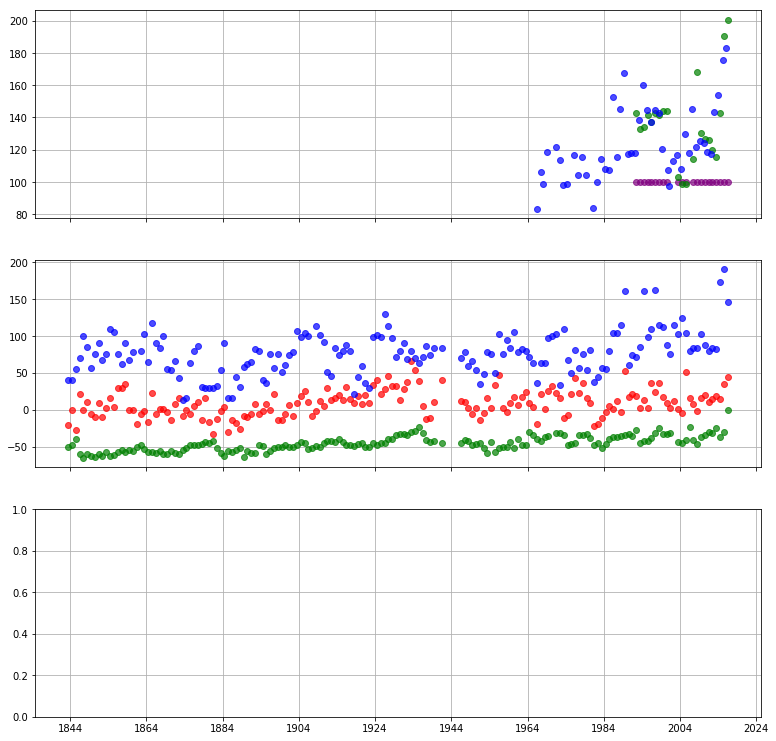

In [18]:
mean_water_df = get_mean_water_df()
mkl_df = get_mkl_df()
bkltkltnd_df = get_bkltkltnd_df()
df_df = get_dune_foot_df()
transect_data = get_transect_data()
nourishment_df = get_nourishment_df()
nourishment_grid_df = get_nourishment_grid_df(id=4001240)
fig, ax = indicators(transect=transect_data,
                     mkl=mkl_df,
                     bkltkltnd=bkltkltnd_df,
                     mean_water=mean_water_df,
                     dune_foot=df_df,
                     nourishment=nourishment_grid_df)


In [57]:
from matplotlib.patches import Rectangle
transect=transect_data,
mkl=mkl_df,
bkltkltnd=bkltkltnd_df,
mean_water=mean_water_df,
dune_foot=df_df,
nourishment_grid_df = get_nourishment_grid_df(id=4001240)
nourishment=nourishment_grid_df
mkl_t = mkl['time_MKL']
mkl_y = mkl['momentary_coastline']
bkltkltnd_t = bkltkltnd['time']
bkl_y = bkltkltnd['basal_coastline']
tkl_y = bkltkltnd['testing_coastline']
mw_t = mean_water['time']
mhw_y = mean_water['mean_high_water_cross']
mlw_y = mean_water['mean_low_water_cross']
df_t = dune_foot['time']
df3_y = dune_foot['dune_foot_threeNAP_cross']
dfu_y = dune_foot['dune_foot_upperMKL_cross']
n_t = nourishment['time']
n_y = nourishment.drop('time', axis=1) #[volume_beach,volume_shoreface,volume_dune,volume_other,time_start_beach,time_start_shoreface,time_start_dune,time_start_other,time_end_beach,time_end_shoreface,time_end_dune,time_end_other]

fig, ax = plt.subplots(3, figsize=(13, 13), sharex=True)
#ax[0].set_title('Coastal Indicators')
ax[0].plot(bkltkltnd_t, bkl_y,'o',color='purple',alpha=0.7,label='Basal Coastline')
ax[0].hold(True)
ax[0].grid(True)
ax[0].plot(bkltkltnd_t, tkl_y,'o',color='green',alpha=0.7,label='Testing Coastline')
ax[0].plot(mkl_t, mkl_y,'o',color='blue',alpha=0.7, label='Momentary Coastline')
ax[1].plot(mw_t, mhw_y,'ro',alpha=0.7,label='Mean High Water')
ax[1].hold(True)
ax[1].grid(True)
ax[1].plot(mw_t, mlw_y,'bo',alpha=0.7,label='Mean Low Water')
ax[1].plot(df_t, df3_y,'go',alpha=0.7, label='Dune Foot 3NAP')
#ax[1].plot(df_t, dfu_y,'o',alpha=0.7, label='Dune Foot MKL')
# set the x,y axis
ax[0].set_xlim(np.min(mw_t), np.max(mw_t))
ax[1].set_xlim(np.min(mw_t), np.max(mw_t))
# set axis labels
ax[0].set_ylabel('Cross shore distance [m]')
ax[1].set_ylabel('Cross shore distance [m]')
# set legend
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')

#HERE to change
if np.sum(np.sum(n_y[volume_beach,volume_shoreface,volume_dune,volume_other]))==0:
    ax[2].grid(True)
    color=['yellow','blue','orange','red']
    lab=['beach', 'shoreface','dune','other']
    boxes = [[],[],[],[]]
    ii=-150 # distance if overlapping
    for cc,ll,box in zip(color, lab, boxes):
        ii = ii+50; 
        for tt, yy in zip(n_t.reset_index()['time'], n_y.reset_index()[str('volume_'+ll)]):
            startTime = tt.to_pydatetime()
            start = matplotlib.dates.date2num(startTime)
            r=Rectangle((start+ii,0),width=365,height=yy,facecolor=cc, edgecolor='black', alpha=0.5,label=ll)
            box.append(r) # durationnnnnnnn of one year
            pc = matplotlib.collections.PatchCollection(box,facecolor=cc, edgecolor='black', alpha=0.5)
        ax[2].add_collection(pc)


    ax[2].set_xlim(np.min(mw_t), np.max(mw_t))
    ax[2].set_ylim(0, np.max(np.max(n_y))+50)


    ax[2].set_ylabel('Nourishments [$m^3/m$]')
    ax[2].set_xlabel('Measurement time [y]')


    ax[2].legend(tuple([bb[0] for bb in boxes]),tuple(lab),loc='upper left')

date_locator = matplotlib.dates.AutoDateLocator()
date_formatter = matplotlib.dates.AutoDateFormatter(date_locator)


/home/giosans/.virtualenvs/cv/lib/python3.4/site-packages/ipykernel_launcher.py:19: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/giosans/.virtualenvs/cv/lib/python3.4/site-packages/ipykernel_launcher.py:20: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


TypeError: tuple indices must be integers, not str

In [54]:
id=7003900
transect_idx = np.searchsorted(ids, id)
variables = {
    'type': {"var": 'type', "slice": np.s_[:]},
    "volume": {"var": "volume", "slice": np.s_[transect_idx,:,:]},
    "time_num_start": {"var": "time_start", "slice": np.s_[transect_idx,:,:]},
    "time_num_end": {"var": "time_end", "slice": np.s_[transect_idx,:,:]},
    "t": {"var": 'time', "slice": np.s_[:]}
}

data = {}
with netCDF4.Dataset(DATASETS['nourishments']) as ds:
    for var, props in variables.items():
        data[var] = ds.variables[props['var']][props['slice']]
    time_units = ds.variables['time'].units
    time_start_units = ds.variables['time_start'].units
    time_end_units = ds.variables['time_start'].units # time_end had a bug
data["time_num_start"][np.isnan(data["time_num_start"])]=0
data["time_num_end"][np.isnan(data["time_num_end"])]=0
#data["time_num_start"].fill_value=float(0)
#print(data["time_num_start"].data)
#print(data["time_num_start"].set_fill_value(0))
data["time_start"] = netCDF4.num2date(data["time_num_start"], time_start_units)
data["time_end"] = netCDF4.num2date(data["time_num_end"], time_end_units)
data['time'] = netCDF4.num2date(data['t'], time_units)

/home/giosans/.virtualenvs/cv/lib/python3.4/site-packages/ipykernel_launcher.py:18: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/giosans/.virtualenvs/cv/lib/python3.4/site-packages/ipykernel_launcher.py:19: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


In [55]:
data["time_num_start"]

masked_array(data =
 [[0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 10743.0 0.0 0.0]
 [11109.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [